In [321]:
# Import simulation packages
import xtrack as xt
import xpart as xp
import xobjects as xo
from cpymad.madx import Madx

# Import scientific packages
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import scipy as sp
from scipy import constants
import scipy.signal
from scipy.signal import chirp, spectrogram

# Import custom signal generator
from signal_gen import generate_afg_chirp, kick_angle

# Import timing packages
from tqdm import tqdm
import time as timing

# Import standard packages
import os
import json
import sys
import pickle as pkl
from collections import Counter

import requests


In [322]:
# Conversion factors
RAD_TO_MRAD = 1000
M_TO_MM = 1000
MS_TO_S = 1e-3

# Beam parameters
REL_GAMMA = 25.598474067
REL_BETA = np.sqrt(1-REL_GAMMA**(-2))

exn = 2e-6
eyn = 2e-6
ex = exn/(REL_BETA*REL_GAMMA)
ey = eyn/(REL_BETA*REL_GAMMA)

p = 5.392 # beam momentum (GeV/c)
momentum = p # beam momentum (GeV/c)
Brho = p*3.3356

DPP_FACTOR = 1.54e-3
# DPP_FACTOR = 0*1.54e-3

PARENT_DIR = "."
os.makedirs(PARENT_DIR, exist_ok=True)

# Use the PS lattice as of 24 may
LATTICE = "ps_24May.seq"

print(f"Parent Directory: {PARENT_DIR}")
mad = Madx(stdout=False)

# Import PS lattice
# mad.call(LATTICE)

mad.input(requests.get("https://gitlab.cern.ch/acc-models/acc-models-ps/-/raw/2022/ps_mu.seq").text)
mad.input(requests.get("https://gitlab.cern.ch/acc-models/acc-models-ps/-/raw/2022/ps_ss.seq").text)
mad.input(requests.get("https://gitlab.cern.ch/acc-models/acc-models-ps/-/raw/2022/scenarios/east/4_slow_extraction/ps_se_east.str").text)

mad.command.beam(
    particle="PROTON",
    pc = p,
    ex = ex,
    ey = ey,
    charge = 1
)
mad.input(f"BRHO      := BEAM->PC * 3.3356;")
mad.use(sequence="PS")

# turn off 23 for ions
mad.input("kPEBSW23 := 0;")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
mad.input('savebeta, label=bumped23, place = PR.BPM23;')

def tune_match(Qx,Qxp,Qy,Qyp,p,ex,ey):
    
    mad.input('''
    ptc_twiss_macro(order, dp, slice_flag): macro = {
    ptc_create_universe;
    ptc_create_layout, time=false, model=2, exact=true, method=6, nst=3;
    IF (slice_flag == 1){
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,l,x,px,beta11,beta22,disp1,k1l;
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, slice_magnets=true;
    }
    ELSE{
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,x,px,beta11,alfa11,beta22,alfa22,disp1,disp2,mu1,mu2,energy,l,angle,K1L,K2L,K3L,HKICK,SLOT_ID;    
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, normal;
    }
    ptc_end;
    };

    ''')
    
    #/**********************************************************************************
    # *                        Matching using the PFW
    #***********************************************************************************/
    mad.input("Qx   := "+str(Qx)+"; !Horizontal Tune")
    mad.input("Qxp  := "+str(Qxp)+"; !Horizontal Chromaticity")

    mad.input("Qy   := "+str(Qy)+"; !Vertical Tune")
    mad.input("Qyp  := "+str(Qyp)+"; !Vertical Chromaticity")

    mad.input('''
    use, sequence=PS;
    match, use_macro;
            vary, name = k1prpfwf;
            vary, name = k1prpfwd;
            vary, name = k2prpfwf;
            vary, name = k2prpfwd;
            use_macro, name = ptc_twiss_macro(2,0,0);
            constraint, expr = table(ptc_twiss_summary,Q1)  = Qx;
            constraint, expr = table(ptc_twiss_summary,Q2)  = Qy;
            constraint, expr = table(ptc_twiss_summary,DQ1) = Qxp;
            constraint, expr = table(ptc_twiss_summary,DQ2) = Qyp;
    jacobian,calls=50000,bisec=3;
    ENDMATCH;
    ''')
    
    mad.use(sequence="PS")
    twiss_tune_matching = mad.twiss().dframe() # Needed to refresh the tune values
    mad.input('qx = table(SUMM, Q1);')
    mad.input('qy = table(SUMM, Q2);')
    mad.input('qxp = table(SUMM, DQ1);')
    mad.input('qyp = table(SUMM, DQ2);')
    
    tune_info_dict = {"Qx": mad.globals["qx"], "Qy": mad.globals["qy"], "Qxp": mad.globals["qxp"], "Qyp": mad.globals["qyp"]}
    pfw_dict = {"k1prpfwf": mad.globals["k1prpfwf"], "k1prpfwd": mad.globals["k1prpfwd"], "k2prpfwf": mad.globals["k2prpfwf"], "k2prpfwd": mad.globals["k2prpfwd"]}

    print (f"H-tune: {round(tune_info_dict['Qx'],3)}, H-Chroma: {round(tune_info_dict['Qxp'],3)}\nV-Tune: {round(tune_info_dict['Qy'],3)}, V-Chroma: {round(tune_info_dict['Qyp'],3)}")
    print (f"")
    print (f"PFW settings: \n  k1prpfwf: {round(pfw_dict['k1prpfwf'],6)}\n  k1prpfwd: {round(pfw_dict['k1prpfwd'],6)}\n  k2prpfwf: {round(pfw_dict['k2prpfwf'],6)}\n  k2prpfwd: {round(pfw_dict['k2prpfwd'],6)}")
    
    return pfw_dict, tune_info_dict

# Data taken from Qmeter
QX_TARGET = 0.325
QPX_TARGET = -0.5

QY_TARGET = 0.256
QPY_TARGET = -0.242

# Match tune using PFWs
pfw_dict_on_resonance, tune_info_on_resonance = tune_match(Qx=QX_TARGET,Qxp=QPX_TARGET,Qy=QY_TARGET,Qyp=QPY_TARGET, p=p, ex=ex, ey=ey)

mad.input("k1prpfwf = "+str(pfw_dict_on_resonance["k1prpfwf"])+";")
mad.input("k1prpfwd = "+str(pfw_dict_on_resonance["k1prpfwd"])+";")
mad.input("k2prpfwf = "+str(pfw_dict_on_resonance["k2prpfwf"])+";")
mad.input("k2prpfwd = "+str(pfw_dict_on_resonance["k2prpfwd"])+";")

# Makethin with 4 slices
QUAD_SLICE = 4
mad.use(sequence='ps')
mad.select(flag='makethin', class_='rbend', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='quadrupole', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='sbend', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='hkicker', slice_=QUAD_SLICE, thick=False)
mad.select(flag='makethin', class_='sextupole', slice_=2)
mad.makethin(sequence='ps')
twiss_after_makethin = mad.twiss().dframe()

print("> Import Complete, MAD-X is ready to go!")

Parent Directory: .
H-tune: 6.325, H-Chroma: -0.508
V-Tune: 6.256, V-Chroma: -0.245

PFW settings: 
  k1prpfwf: 4.2e-05
  k1prpfwd: -0.000131
  k2prpfwf: 0.006612
  k2prpfwd: -0.017293
> Import Complete, MAD-X is ready to go!


In [323]:
Qx = tune_info_on_resonance['Qx']
Qxp = tune_info_on_resonance['Qxp']
print(f"Qx = {Qx}, Qxp = {Qxp}")

Qx = 6.324993445183833, Qxp = -0.5077091944217004


Text(0, 0.5, 'x [m]')

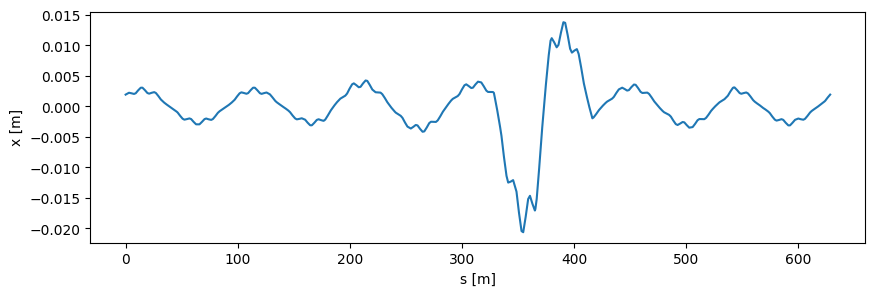

In [324]:
fig, ax = plt.subplots(figsize=(10,3))

ax.plot(twiss_parameters.s, twiss_parameters.x)
ax.set_xlabel("s [m]")
ax.set_ylabel("x [m]")

In [325]:
# get the index where name == "pe.smh57"
index = np.where(twiss_parameters.name == "pe.smh57")

# get the betx at that index
betx0 = twiss_parameters.betx[index][0]
alfx0 = twiss_parameters.alfx[index][0]

In [326]:
print(betx0)
print(alfx0)

31.859456510933875
-0.31361064958600066


In [439]:
volt = 0 # tfb voltage
interval = 1 # chirp repetition interval milliseconds
rf10MHz_enable = '0' # 10MHz cavities on/off
time = 0.004 # total sim time seconds
n_part = 1000 # particles generated
n_turn = "0" # total sim time override

# context
ctx = xo.ContextCpu()

# Convert Line to Xsuite
mad.use(sequence="PS")
line = xt.Line.from_madx_sequence(
    mad.sequence(), allow_thick=True
    )

line.particle_ref = xp.Particles(
    mass0=xp.PROTON_MASS_EV,
    q0=1,
    p0c=p*sp.constants.c
)

# Calculate Frev
line.build_tracker(_context=ctx)
twiss_parameters = line.twiss(method='4d')
trev = twiss_parameters['T_rev0']
frev = 1/trev
line.unfreeze()
print(f"frev = {frev}")
# frev = 412657.22413208015


# N_turn override
if n_turn is None or n_turn == 0 or n_turn == '0': 
    print("> n_turn not specified, calculating from time")
    n_turn = int(float(time)*frev)
    print(f">This sim will run for {n_turn} turns")
else:
    n_turn = int(n_turn)
    print("> n_turn overridden")

rf10MHz_enable = True if rf10MHz_enable == '1' else False    

# Septa Config
SEPTA_X_MM = -60
septum = xt.LimitRect(
        min_x = SEPTA_X_MM*0.001, # in meters
    )
line.insert_element(
    element = septum,
    name = "SEPTUM",
    index = 'pe.smh57'
)

# TFB Config
rfko_kick = kick_angle(float(volt), Brho)

# Chirp
def generate_chirp(start_freq, end_freq, duration, fs):
    # Time array
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    # Generate chirp signal
    chirp_signal = chirp(t, start_freq, duration, end_freq)
    
    return t, chirp_signal

# Chirp
def generate_chirp_non_linear(start_freq, end_freq, duration, fs):
    # Time array
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    
    # Half duration
    half_duration = duration / 2
    
    # Generate two halves of chirp signal
    chirp_signal_first_half = chirp(t[:int(fs * half_duration)], start_freq, half_duration, end_freq)
    chirp_signal_second_half = np.zeros_like(t[int(fs * half_duration):])
    
    # Concatenate the two halves
    chirp_signal = np.concatenate((chirp_signal_first_half, chirp_signal_second_half))
    
    return t, chirp_signal


# Define your parameters for a single chirp
start_freq = frev*90/100
end_freq = frev*110/100
duration = 1/1000  # in seconds
sampling_freq = 1e9  # sampling frequency

# Generate and plot the repeated chirp
t, chirp_signal = generate_chirp_non_linear(start_freq, end_freq, duration, sampling_freq)

# Exciter config; the duration parameter tells it to repeat the chirp_signal
rfko_exciter = xt.Exciter(
    _context = ctx,
    samples = chirp_signal,
    sampling_frequency = sampling_freq,
    frev = frev,
    duration = float(time),
    start_turn = 0,
    knl = [rfko_kick]
)
line.insert_element(
    element = rfko_exciter,
    name = f'EXCITER',
    index = 'pr.kfb97'
)

# RF Cavity Config; voltage 0 if disabled
if rf10MHz_enable:
    RF_VOLTAGE = 130e3 # V
else:
    RF_VOLTAGE = 0

RF_HARMONIC = 8
RF_FREQUENCY = frev * RF_HARMONIC

PHASE = 0 # rising-edge

rf_cavity = xt.Cavity(
    _context = ctx,
    voltage = RF_VOLTAGE,
    frequency = RF_FREQUENCY,
    lag = PHASE
)

line.insert_element(
    element = rf_cavity,
    name = "rf_cavity",
    at_s = 0
)

# Insert a monitor to record the particles
monitor = xt.ParticlesMonitor(
    num_particles = n_part,
    start_at_turn = 0,
    stop_at_turn = n_turn,
)
line.unfreeze()
line.insert_element(index='pe.smh57', element=monitor, name='septa_monitor')

line.build_tracker(_context=ctx)
line.particle_ref = xp.Particles(
    mass0=xp.PROTON_MASS_EV,
    q0=1,
    p0c=p*scipy.constants.c
)

# Particle Generation

if rf10MHz_enable:
        print("RF present; generating from generate_matched_gaussian_bunch()")
        particles = xp.generate_matched_gaussian_bunch(
            line = line,
            num_particles = int(n_part),
            nemitt_x = exn,
            nemitt_y = eyn,
            sigma_z = 4.3,
            total_intensity_particles = 30e10
        )
else:
    print("RF not present")
    sigmas, sigmas_p = xp.generate_2D_gaussian(int(n_part))
    try:
        particles = line.build_particles(
            method='4d',
            delta = DPP_FACTOR,
            nemitt_x = exn,
            nemitt_y = eyn,
            x_norm=sigmas, 
            px_norm=sigmas_p,
            y_norm=sigmas,
            py_norm=sigmas_p,
        )
        z_array = sp.stats.uniform.rvs(loc=0-twiss_parameters['circumference']/2,
                                        scale = twiss_parameters['circumference'],
                                        size = int(n_part))
        delta_array = sp.stats.norm.rvs(loc=0, scale=DPP_FACTOR/2, size=int(n_part))
        particles.zeta = z_array
        particles.delta = delta_array
    except AssertionError:
        print("Failed line.build, trying xp.build_particles()")
        particles = xp.build_particles(
            particle_ref = line.particle_ref,
            method='4d',
            delta = DPP_FACTOR,
            nemitt_x = exn,
            nemitt_y = eyn,
            x_norm=sigmas, 
            px_norm=sigmas_p,
            y_norm=sigmas,
            py_norm=sigmas_p,
        )
        z_array = sp.stats.uniform.rvs(loc=0-twiss_parameters['circumference']/2,
                                        scale = twiss_parameters['circumference'],
                                        size = int(n_part))
        delta_array = sp.stats.norm.rvs(loc=0, scale=DPP_FACTOR/2, size=int(n_part))
        particles.zeta = z_array
        particles.delta = delta_array
    else:
        print("Generating from line.build_particles()")

Converting sequence "ps": 99%     
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
frev = 412657.224132077
> n_turn not specified, calculating from time
>This sim will run for 1650 turns
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
RF not present
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Generating from line.build_particles()


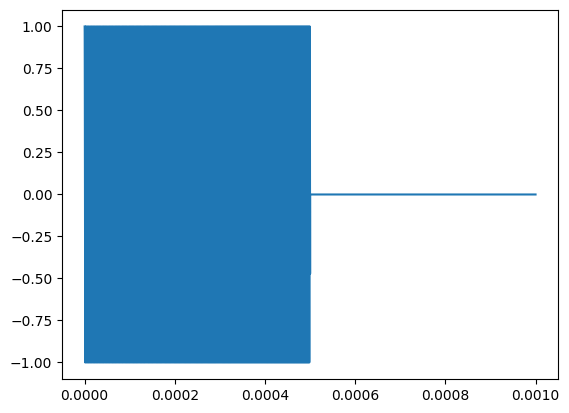

In [440]:
fig, ax = plt.subplots()
ax.plot(t, chirp_signal)

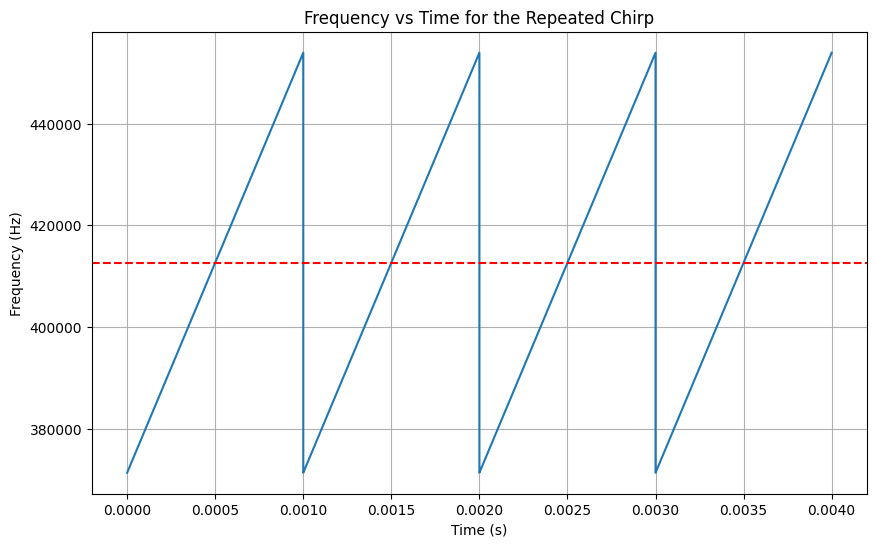

In [441]:
# Number of repetitions
n_repetitions = int(time / duration)

# Generate time and frequency arrays for the repeated chirp
t_repeated = np.concatenate([t + i * duration for i in range(n_repetitions)])
freq_repeated = np.concatenate([np.linspace(start_freq, end_freq, len(t)) for _ in range(n_repetitions)])

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_repeated, freq_repeated)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('Frequency vs Time for the Repeated Chirp')
ax.grid(True)
ax.axhline(frev, c="r", linestyle="--")


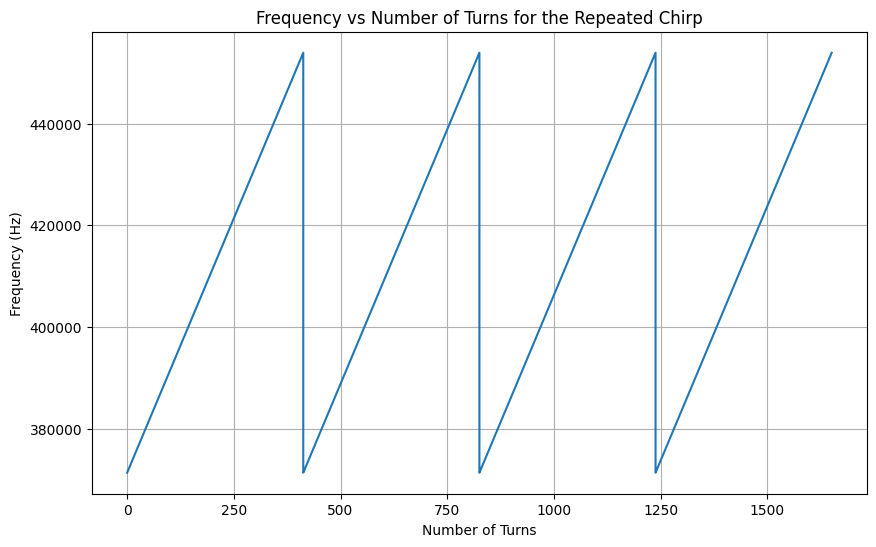

In [442]:
# Generate number of turns and frequency arrays for the repeated chirp
n_turns_repeated = np.concatenate([t * frev + i * duration * frev for i in range(n_repetitions)])
freq_repeated = np.concatenate([np.linspace(start_freq, end_freq, len(t)) for _ in range(n_repetitions)])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(n_turns_repeated, freq_repeated)
plt.xlabel('Number of Turns')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency vs Number of Turns for the Repeated Chirp')
plt.grid(True)
plt.show()


In [443]:
import matplotlib.pyplot as plt

# Number of repetitions
n_repetitions = int(time / duration)

# Generate time and frequency arrays for a single chirp
t_single = t
freq_single = np.concatenate([np.linspace(start_freq, end_freq, len(t) // 2), np.zeros(len(t) // 2)])

# Generate time and frequency arrays for the repeated chirp
t_repeated = np.concatenate([t_single + i * duration for i in range(n_repetitions)])
freq_repeated = np.concatenate([freq_single for _ in range(n_repetitions)])

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_repeated, freq_repeated)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('Frequency vs Time for the Repeated Chirp')
ax.grid(True)
ax.axhline(frev, c="r", linestyle="--")
plt.show()


In [444]:
import matplotlib.pyplot as plt

# Number of repetitions
n_repetitions = int(time / duration)

# Generate time and frequency arrays for a single chirp
t_single = t
freq_single = np.concatenate([np.linspace(start_freq, end_freq, len(t) // 2), np.zeros(len(t) // 2)])

# Generate time and frequency arrays for the repeated chirp
t_repeated = np.concatenate([t_single + i * duration for i in range(n_repetitions)])
freq_repeated = np.concatenate([freq_single for _ in range(n_repetitions)])

# Convert time to number of turns
turns_repeated = t_repeated * frev

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(turns_repeated, freq_repeated)
ax.set_xlabel('Number of Turns')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('Frequency vs Number of Turns for the Repeated Chirp')
ax.grid(True)
ax.axhline(frev, c="r", linestyle="--")
plt.show()


In [445]:
print(f"A single chirp will last for {duration} s = {round(duration*frev,3)} turns")
print(f"The full spill will last {time} s = {round(time*frev,3)} turns")

A single chirp will last for 0.001 s = 412.657 turns
The full spill will last 0.004 s = 1650.629 turns


In [446]:
# Compute and plot the spectrogram
nperseg = 2**17
frequencies, times, Sxx = spectrogram(chirp_signal, fs=sampling_freq, nperseg=nperseg, noverlap=nperseg/2, window='hann')
plt.figure(figsize=(15,5))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='auto')
plt.ylabel('Frequency [Hz]')
plt.ylim(frev*80/100, frev*120/100)
plt.xlabel('Time [sec]')
plt.colorbar(label='dB')
plt.title("Spectrogram of the Chirp Signal")
plt.axhline(frev, c="r", ls="--")

/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_6832/56872213.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='auto')


(371391.5017188693, 453922.94654528477)

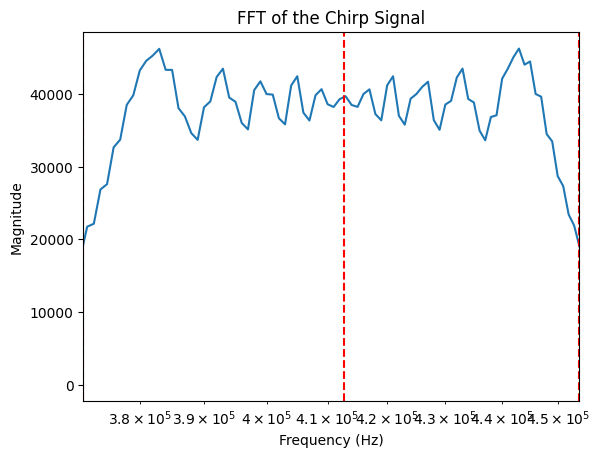

In [447]:
import numpy as np

# Perform FFT
fft_result = np.fft.fft(chirp_signal)
fft_freqs = np.fft.fftfreq(len(chirp_signal), 1/sampling_freq) # assuming chirp_time[1]-chirp_time[0] is equivalent to the inverse of the sampling frequency

# Usually we are interested in the magnitude of the FFT, which is a complex number.
# We also only plot the first half of the frequencies (until Nyquist frequency) for a real signal.
fft_magnitude = np.abs(fft_result)[:len(fft_result)//2]
fft_freqs = fft_freqs[:len(fft_freqs)//2]

# Plot FFT
fig, ax = plt.subplots()
ax.plot(fft_freqs, fft_magnitude)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude")
ax.set_title("FFT of the Chirp Signal")
ax.set_xscale("log")
ax.axvline(frev, c="r", linestyle="--")
ax.axvline(start_freq, c="r", linestyle="--")
ax.axvline(end_freq, c="r", linestyle="--")
ax.set_xlim(frev*0.90, frev*1.10)

In [448]:
# Tracking
time_before = timing.time()
print("> Tracking...")
for _ in tqdm(range(n_turn)):
    line.track(particles, num_turns = 1)
time_after = timing.time()
time_taken = time_after - time_before
print(f"> Tracking done, {time_taken} seconds elapsed")

particles_lost_at_each_turn = np.bincount(ctx.nparray_from_context_array(particles.at_turn))

print("! Script Complete !")


> Tracking...


100%|██████████| 1650/1650 [01:07<00:00, 24.58it/s]

> Tracking done, 67.14665794372559 seconds elapsed
! Script Complete !


# Visualization

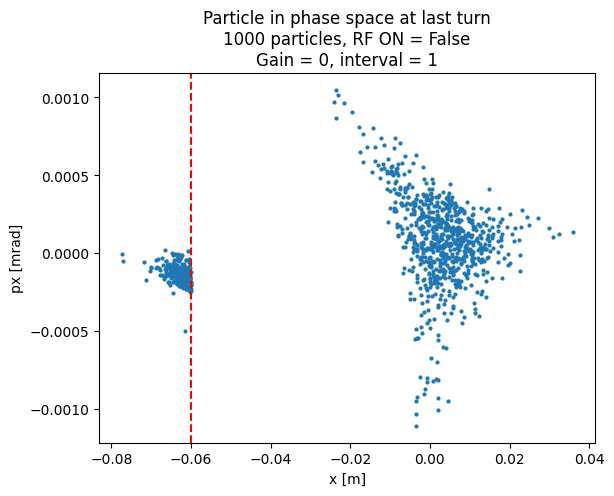

In [390]:
# At the end of the simulation
fig, ax = plt.subplots()
ax.scatter(particles.x, particles.px, s=4)
ax.set_ylabel("px [mrad]")
ax.set_xlabel("x [m]")
ax.set_title(f"Particle in phase space at last turn\n{n_part} particles, RF ON = {rf10MHz_enable}\nGain = {volt}, interval = {interval}")
ax.axvline(SEPTA_X_MM/1000, c="r", linestyle="--")

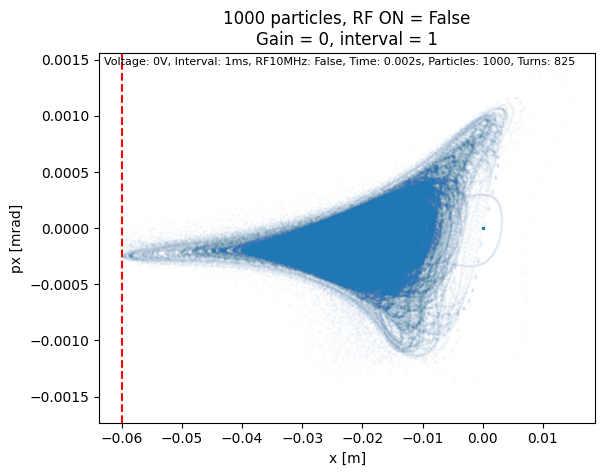

In [391]:
fig, ax = plt.subplots()
turn = 0
x = monitor.x[:,:]
px = monitor.px[:,:]
ax.scatter(x, px, s = 1, alpha=0.01)
ax.axvline(SEPTA_X_MM/1000, c="r", linestyle="--")
ax.set_xlabel("x [m]")
ax.set_ylabel("px [mrad]")
ax.set_title(f"{n_part} particles, RF ON = {rf10MHz_enable}\nGain = {volt}, interval = {interval}")
info = f'Voltage: {volt}V, Interval: {interval}ms, RF10MHz: {rf10MHz_enable}, Time: {time}s, Particles: {n_part}, Turns: {n_turn}'
ax.text(0.01, 0.99, info, transform=ax.transAxes, fontsize=8, va='top')

filename = f'fig/phase_space_voltage_{volt}V_interval_{interval}ms_RF10MHz_{rf10MHz_enable}_time_{time}s_particles_{n_part}_turns_{n_turn}.png'
plt.savefig(filename, facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

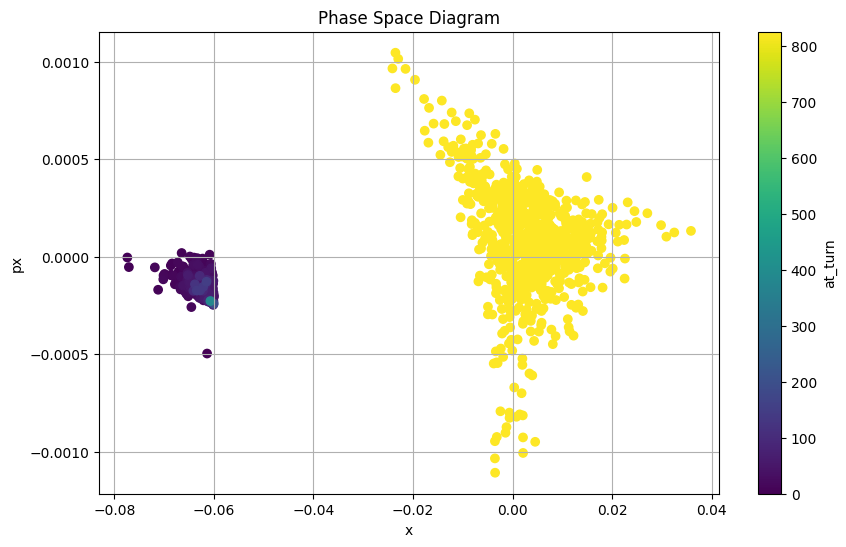

In [392]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming particles.at_turn, particles.x, and particles.px are lists or numpy arrays
data = {
    'at_turn': particles.at_turn,
    'x': particles.x,
    'px': particles.px,
    'delta': particles.delta,
}

df = pd.DataFrame(data)

# Sorting the dataframe by 'at_turn'
df.sort_values('at_turn',inplace=True)

plt.figure(figsize=(10, 6))
sc = plt.scatter(df['x'], df['px'], c=df['at_turn'], cmap='viridis')
plt.colorbar(sc, label='at_turn')
ax.axvline(SEPTA_X_MM/1000, c="r", linestyle="--")
plt.xlabel('x')
plt.ylabel('px')
plt.title('Phase Space Diagram')
plt.grid(True)
plt.show()


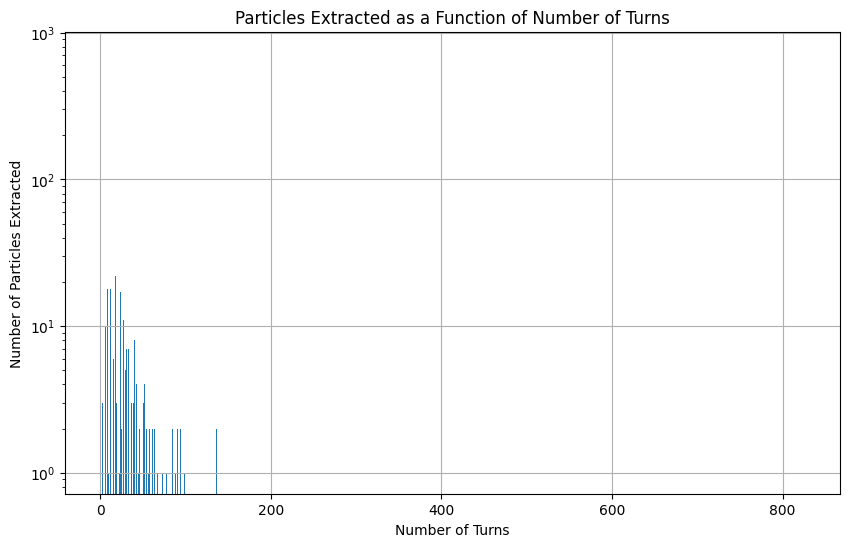

In [393]:
import matplotlib.pyplot as plt

# Group by 'at_turn' and count the number of particles extracted at each turn
particle_counts = df.groupby('at_turn').size()

plt.figure(figsize=(10, 6))
plt.bar(particle_counts.index, particle_counts.values, log=True)
plt.xlabel('Number of Turns')
plt.ylabel('Number of Particles Extracted')
plt.title('Particles Extracted as a Function of Number of Turns')
plt.grid(True)
plt.show()


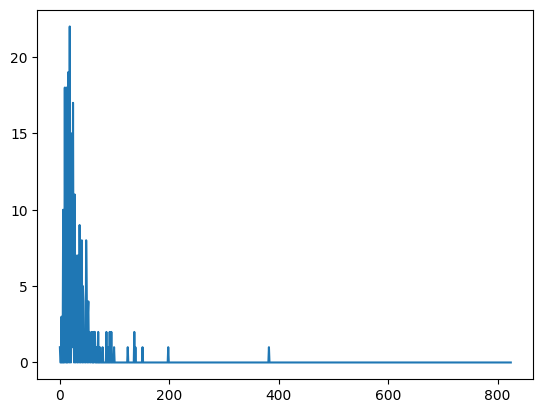

In [394]:
fig, ax = plt.subplots()

number_part_extracted_list = []

for turn in range(n_turn):
    number_part_extracted = len(df.loc[df.at_turn == turn].x)
    number_part_extracted_list.append(number_part_extracted)

ax.plot(number_part_extracted_list)

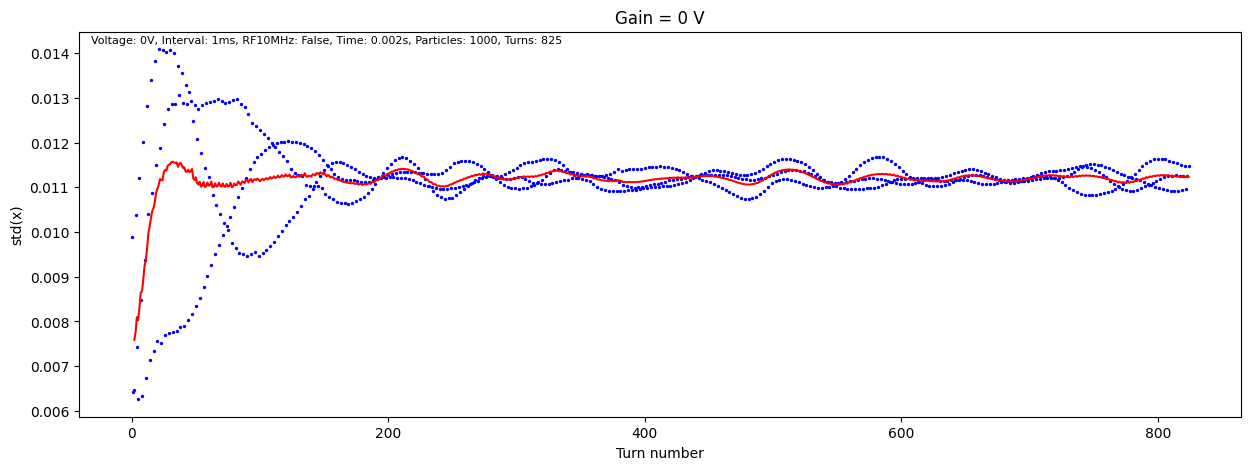

In [395]:
fig, ax = plt.subplots(figsize=(15,5))

# Calculate standard deviation in a vectorized manner
std_x = np.std(monitor.x, axis=0)

# Create data points for each turn
turns = np.arange(n_turn)

# Plot the standard deviations
ax.scatter(turns, std_x, s=2, c="b")

# Compute the rolling average using pandas
std_x_series = pd.Series(std_x)
rolling_average = std_x_series.rolling(window=3).mean()

# Plot the rolling average
ax.plot(turns, rolling_average, c="r")

ax.set_xlabel("Turn number")
ax.set_ylabel("std(x)")
ax.set_title(f"Gain = {volt} V")
info = f'Voltage: {volt}V, Interval: {interval}ms, RF10MHz: {rf10MHz_enable}, Time: {time}s, Particles: {n_part}, Turns: {n_turn}'
ax.text(0.01, 0.99, info, transform=ax.transAxes, fontsize=8, va='top')

filename = f'fig/std_x_voltage_{volt}V_interval_{interval}ms_RF10MHz_{rf10MHz_enable}_time_{time}s_particles_{n_part}_turns_{n_turn}.png'
plt.savefig(filename, facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

MovieWriter ffmpeg unavailable; using Pillow instead.


Creating frame: 0/825
Creating frame: 0/825
Creating frame: 0/825
Creating frame: 0/825
Creating frame: 3/825
Creating frame: 6/825
Creating frame: 9/825
Creating frame: 12/825
Creating frame: 15/825
Creating frame: 18/825
Creating frame: 21/825
Creating frame: 24/825
Creating frame: 27/825
Creating frame: 30/825
Creating frame: 33/825
Creating frame: 36/825
Creating frame: 39/825
Creating frame: 42/825
Creating frame: 45/825
Creating frame: 48/825
Creating frame: 51/825
Creating frame: 54/825
Creating frame: 57/825
Creating frame: 60/825
Creating frame: 63/825
Creating frame: 66/825
Creating frame: 69/825
Creating frame: 72/825
Creating frame: 75/825
Creating frame: 78/825
Creating frame: 81/825
Creating frame: 84/825
Creating frame: 87/825
Creating frame: 90/825
Creating frame: 93/825
Creating frame: 96/825
Creating frame: 99/825
Creating frame: 102/825
Creating frame: 105/825
Creating frame: 108/825
Creating frame: 111/825
Creating frame: 114/825
Creating frame: 117/825
Creating fra

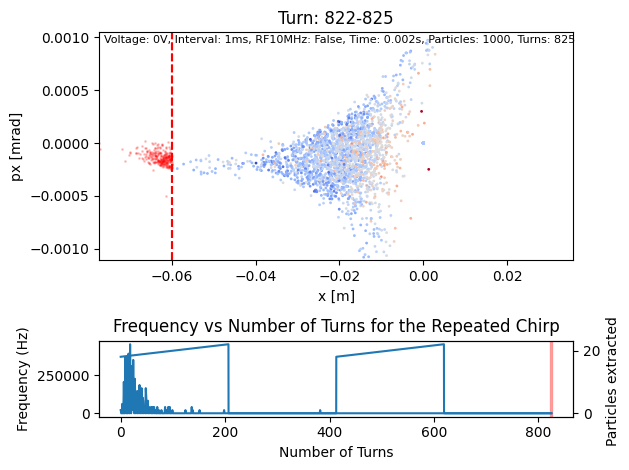

In [396]:
from matplotlib.animation import FuncAnimation
fig, (ax, ax2) = plt.subplots(2, 1, height_ratios=[3,1], tight_layout=True)

# Total number of turns
num_turns = len(monitor.x[1])

# Initialize a scatter plot
scat = ax.scatter([], [], s=1)

# Number of repetitions
n_repetitions = int(time / duration)

# Generate time and frequency arrays for a single chirp
t_single = t
freq_single = np.concatenate([np.linspace(start_freq, end_freq, len(t) // 2), np.zeros(len(t) // 2)])

# Generate time and frequency arrays for the repeated chirp
t_repeated = np.concatenate([t_single + i * duration for i in range(n_repetitions)])
freq_repeated = np.concatenate([freq_single for _ in range(n_repetitions)])

# Convert time to number of turns
turns_repeated = t_repeated * frev

# Add second plot
ax2.plot(turns_repeated, freq_repeated)
ax2.set_xlabel('Number of Turns')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_title('Frequency vs Number of Turns for the Repeated Chirp')

highlight = ax2.axvspan(0, 0, color='red', alpha=0.3)  # initialize highlight with dummy values

x_combined = np.concatenate([df.x, monitor.x[:,0]])
px_combined = np.concatenate([df.px, monitor.px[:,0]])

ax3=ax2.twinx()
ax3.plot(number_part_extracted_list)
ax3.set_ylabel('Particles extracted ')

# Function to update the scatter plot for each frame
def update(frame):
    ax.clear()
    print(f'Creating frame: {frame}/{num_turns}')  # print a progress message
    ax.scatter(df.loc[df.at_turn <= frame].x, df.loc[df.at_turn <= frame].px, s=1, c="r", alpha=0.2)
    for turn in range(frame, min(frame + 3, num_turns)):
        x = monitor.x[:, turn]
        px = monitor.px[:, turn]
        delta = monitor.delta[:, turn]
        ax.scatter(x, px, s=1, c=delta, cmap = "coolwarm")
        ax.scatter(df.loc[df.at_turn == turn].x, df.loc[df.at_turn == turn].px, s=1, c="gold", alpha=1.0)
    ax.axvline(SEPTA_X_MM/1000, c="r", linestyle="--")
    ax.set_xlim(np.min(x_combined), np.max(x_combined))
    ax.set_ylim(np.min(px_combined), np.max(px_combined))
    ax.set_title('Turn: ' + str(frame) + '-' + str(min(frame + 3, num_turns)))
    ax.axvline(SEPTA_X_MM/1000, c="r", linestyle="--")
    info = f'Voltage: {volt}V, Interval: {interval}ms, RF10MHz: {rf10MHz_enable}, Time: {time}s, Particles: {n_part}, Turns: {n_turn}'
    ax.text(0.01, 0.99, info, transform=ax.transAxes, fontsize=8, va='top')
    ax.set_xlabel("x [m]")
    ax.set_ylabel("px [mrad]")

    # update the highlight in the second plot
    highlight.set_xy([(frame, 0), (min(frame + 3, num_turns), 0), (min(frame + 3, num_turns), 1), (frame, 1)])

    return scat,

# Create an animation
ani = FuncAnimation(fig, update, frames=range(0, n_turn, 3), blit=True)
# ani = FuncAnimation(fig, update, frames=range(0, 30, 3), blit=True)

# Save the animation as a gif
filename = f'gif/phase_space_chirp_voltage_{volt}V_interval_{interval}ms_RF10MHz_{rf10MHz_enable}_time_{time}s_particles_{n_part}_turns_{n_turn}.gif'
ani.save(filename, dpi=300)
plt.show()


# Plot the particles as a function of their momentum offset

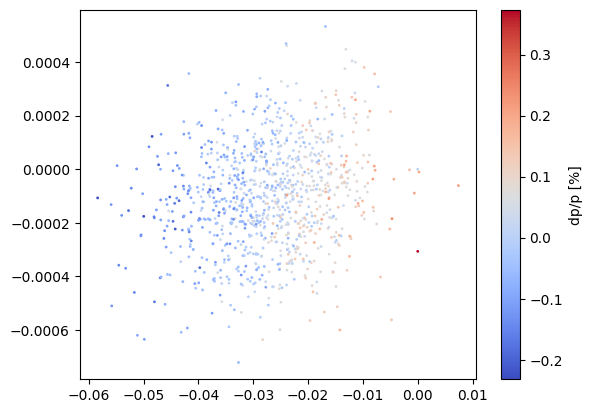

In [397]:
turn = 0

fig, ax = plt.subplots()

x = monitor.x[:, turn]
px = monitor.px[:, turn]
delta = monitor.delta[:, turn]

sc = ax.scatter(x, px, c=delta*100, s=1, cmap='coolwarm')

# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label('dp/p [%]')

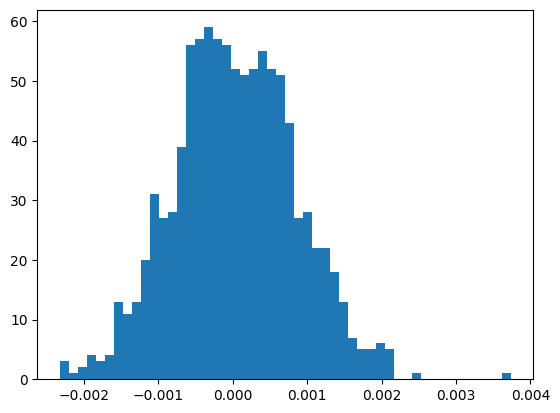

In [398]:
plt.hist(particles.delta, bins=50);

Text(0, 0.5, 'Amplitude x [m]')

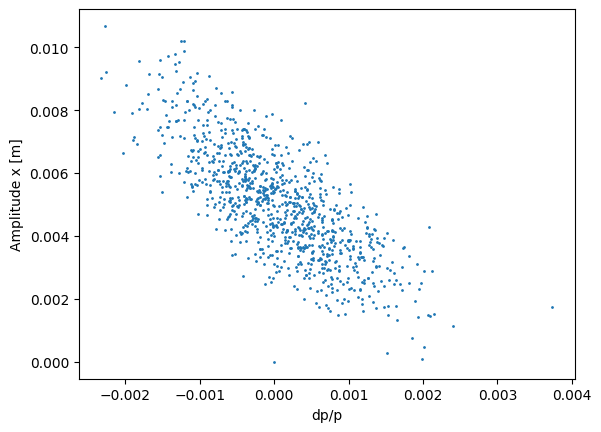

In [399]:
turn = 0

x = monitor.x[:, turn]
px = monitor.px[:, turn]

xn = x*1/np.sqrt(betx0)
pxn = (alfx0/np.sqrt(betx0))*x + np.sqrt(betx0)*px
amplitude = np.sqrt(xn**2 + pxn**2)


fig, ax = plt.subplots()


x = monitor.x[:, turn]
delta = monitor.delta[:, turn]

ax.scatter(delta, amplitude, s=1)

# ax.scatter(df.loc[df.at_turn == turn].delta, amplitude, s=1, c="r", alpha=1.0)

ax.set_xlabel("dp/p")
ax.set_ylabel("Amplitude x [m]")

In [400]:
x = monitor.x[:, turn]
px = monitor.px[:, turn]

xn = x*1/np.sqrt(betx0)
pxn = (alfx0/np.sqrt(betx0))*x + np.sqrt(betx0)*px
amplitude = np.sqrt(xn**2 + pxn**2)

# Steinbach diagram

MovieWriter ffmpeg unavailable; using Pillow instead.


Creating frame: 0/825
Creating frame: 0/825
Creating frame: 0/825
Creating frame: 0/825
Creating frame: 3/825
Creating frame: 6/825
Creating frame: 9/825
Creating frame: 12/825
Creating frame: 15/825
Creating frame: 18/825
Creating frame: 21/825
Creating frame: 24/825
Creating frame: 27/825
Creating frame: 30/825
Creating frame: 33/825
Creating frame: 36/825
Creating frame: 39/825
Creating frame: 42/825
Creating frame: 45/825
Creating frame: 48/825
Creating frame: 51/825
Creating frame: 54/825
Creating frame: 57/825
Creating frame: 60/825
Creating frame: 63/825
Creating frame: 66/825
Creating frame: 69/825
Creating frame: 72/825
Creating frame: 75/825
Creating frame: 78/825
Creating frame: 81/825
Creating frame: 84/825
Creating frame: 87/825
Creating frame: 90/825
Creating frame: 93/825
Creating frame: 96/825
Creating frame: 99/825
Creating frame: 102/825
Creating frame: 105/825
Creating frame: 108/825
Creating frame: 111/825
Creating frame: 114/825
Creating frame: 117/825
Creating fra

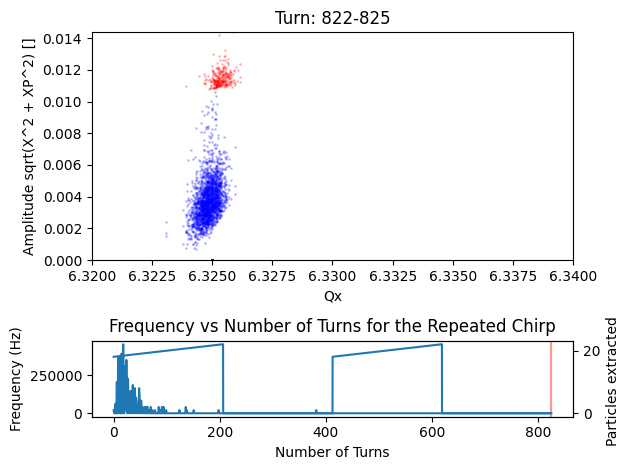

In [401]:
from matplotlib.animation import FuncAnimation

fig, (ax, ax2) = plt.subplots(2,1, height_ratios=[3,1], tight_layout=True)

# Total number of turns
num_turns = len(monitor.x[1])

# Initialize a scatter plot
scat = ax.scatter([], [], s=1)

# Determine global min and max values for x and delta

x = monitor.x[:, :]
px = monitor.px[:, :]
delta = monitor.delta[:, :]

xn = x*1/np.sqrt(betx0)
pxn = (alfx0/np.sqrt(betx0))*x + np.sqrt(betx0)*px
amplitude_monitor = np.sqrt(xn**2 + pxn**2)

x = df.x
px = df.px
xn = x*1/np.sqrt(betx0)
pxn = (alfx0/np.sqrt(betx0))*x + np.sqrt(betx0)*px
amplitude_circulating = np.sqrt(xn**2 + pxn**2)


amplitude_combined = np.concatenate([amplitude_monitor.reshape(-1), amplitude_circulating])
delta_combined = np.concatenate([df.delta, monitor.delta[:,0]])


amplitude_min = np.min(amplitude_combined)
amplitude_max = np.max(amplitude_combined)
delta_min = np.min(delta_combined)
delta_max = np.max(delta_combined)

# Add second plot
ax2.plot(turns_repeated, freq_repeated)
ax2.set_xlabel('Number of Turns')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_title('Frequency vs Number of Turns for the Repeated Chirp')

highlight = ax2.axvspan(0, 0, color='red', alpha=0.3)  # initialize highlight with dummy values


ax3=ax2.twinx()
ax3.plot(number_part_extracted_list)
ax3.set_ylabel('Particles extracted ')


# Function to update the scatter plot for each frame
def update(frame):
    ax.clear()
    print(f'Creating frame: {frame}/{num_turns}')  # print a progress message

    x = df.loc[df.at_turn <= frame].x
    px = df.loc[df.at_turn <= frame].px
    xn = x*1/np.sqrt(betx0)
    pxn = (alfx0/np.sqrt(betx0))*x + np.sqrt(betx0)*px
    amplitude = np.sqrt(xn**2 + pxn**2)
    delta = df.loc[df.at_turn <= frame].delta

    Qx_delta = Qx + Qxp*delta

    ax.scatter(Qx_delta, amplitude, s=1, c="r", alpha=0.2)
    for turn in range(frame, min(frame + 3, num_turns)):  # plot 3 turns for each frame

        # Monitor, particles circulating
        x = monitor.x[:, turn]
        px = monitor.px[:, turn]
        delta = monitor.delta[:, turn]

        Qx_monitor = Qx + Qxp*delta

        xn = x*1/np.sqrt(betx0)
        pxn = (alfx0/np.sqrt(betx0))*x + np.sqrt(betx0)*px
        amplitude = np.sqrt(xn**2 + pxn**2)

        scat = ax.scatter(Qx_monitor, amplitude, s=1, alpha=0.2, c="b")


        # DF, particles lost
        x = df.loc[df.at_turn == turn].x
        px = df.loc[df.at_turn == turn].px
        xn = x*1/np.sqrt(betx0)
        pxn = (alfx0/np.sqrt(betx0))*x + np.sqrt(betx0)*px
        amplitude = np.sqrt(xn**2 + pxn**2)
        delta = df.loc[df.at_turn == turn].delta

        Qx_delta = Qx + Qxp*delta

        ax.scatter(Qx_delta, amplitude, s=1, c="r", alpha=1.0)
    ax.set_title('Turn: ' + str(frame) + '-' + str(min(frame + 3, num_turns)))
    ax.set_xlabel("Qx")
    ax.set_ylabel("Amplitude sqrt(X^2 + XP^2) []")
    
    # update the highlight in the second plot
    highlight.set_xy([(frame, 0), (min(frame + 3, num_turns), 0), (min(frame + 3, num_turns), 1), (frame, 1)])

    # Set fixed axis limits
    ax.set_xlim(6.32, 6.34)
    ax.set_ylim(amplitude_min, amplitude_max)

    return scat,

# Create an animation
ani = FuncAnimation(fig, update, frames=range(0, num_turns, 3), blit=True)  # update every 3 turns
# ani = FuncAnimation(fig, update, frames=range(0, 30, 3), blit=True)  # update every 3 turns

# Save the animation as a gif
filename = f'gif/steinbach_diagram_turns_{num_turns}.gif'
ani.save(filename, dpi=300)
plt.show()


$\delta Q$

MovieWriter ffmpeg unavailable; using Pillow instead.


Creating frame: 0/825
Creating frame: 0/825
Creating frame: 0/825
Creating frame: 0/825
Creating frame: 3/825
Creating frame: 6/825
Creating frame: 9/825
Creating frame: 12/825
Creating frame: 15/825
Creating frame: 18/825
Creating frame: 21/825
Creating frame: 24/825
Creating frame: 27/825
Creating frame: 30/825
Creating frame: 33/825
Creating frame: 36/825
Creating frame: 39/825
Creating frame: 42/825
Creating frame: 45/825
Creating frame: 48/825
Creating frame: 51/825
Creating frame: 54/825
Creating frame: 57/825
Creating frame: 60/825
Creating frame: 63/825
Creating frame: 66/825
Creating frame: 69/825
Creating frame: 72/825
Creating frame: 75/825
Creating frame: 78/825
Creating frame: 81/825
Creating frame: 84/825
Creating frame: 87/825
Creating frame: 90/825
Creating frame: 93/825
Creating frame: 96/825
Creating frame: 99/825
Creating frame: 102/825
Creating frame: 105/825
Creating frame: 108/825
Creating frame: 111/825
Creating frame: 114/825
Creating frame: 117/825
Creating fra

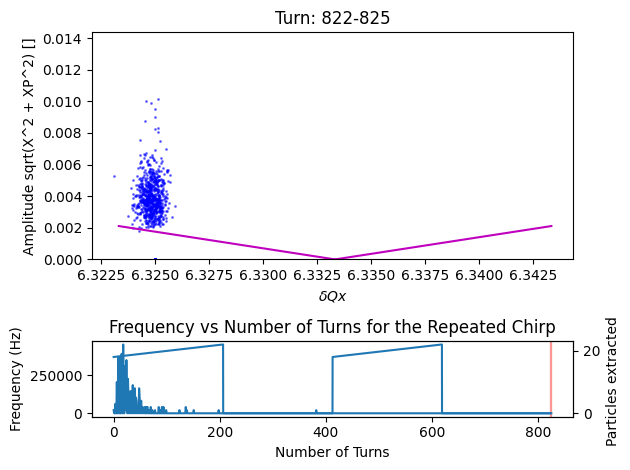

In [411]:
from matplotlib.animation import FuncAnimation

fig, (ax, ax2) = plt.subplots(2,1, height_ratios=[3,1], tight_layout=True)

# Total number of turns
num_turns = len(monitor.x[1])

# Initialize a scatter plot
scat = ax.scatter([], [], s=1)

# Determine global min and max values for x and delta

x = monitor.x[:, :]
px = monitor.px[:, :]
delta = monitor.delta[:, :]

xn = x*1/np.sqrt(betx0)
pxn = (alfx0/np.sqrt(betx0))*x + np.sqrt(betx0)*px
amplitude_monitor = np.sqrt(xn**2 + pxn**2)

x = df.x
px = df.px
xn = x*1/np.sqrt(betx0)
pxn = (alfx0/np.sqrt(betx0))*x + np.sqrt(betx0)*px
amplitude_circulating = np.sqrt(xn**2 + pxn**2)


amplitude_combined = np.concatenate([amplitude_monitor.reshape(-1), amplitude_circulating])
delta_combined = np.concatenate([df.delta, monitor.delta[:,0]])


amplitude_min = np.min(amplitude_combined)
amplitude_max = np.max(amplitude_combined)
delta_min = np.min(delta_combined)
delta_max = np.max(delta_combined)

# Add second plot
ax2.plot(turns_repeated, freq_repeated)
ax2.set_xlabel('Number of Turns')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_title('Frequency vs Number of Turns for the Repeated Chirp')

highlight = ax2.axvspan(0, 0, color='red', alpha=0.3)  # initialize highlight with dummy values


ax3=ax2.twinx()
ax3.plot(number_part_extracted_list)
ax3.set_ylabel('Particles extracted ')


# Function to update the scatter plot for each frame
def update(frame):
    ax.clear()
    print(f'Creating frame: {frame}/{num_turns}')  # print a progress message

    # x = df.loc[df.at_turn <= frame].x
    # px = df.loc[df.at_turn <= frame].px
    # xn = x*1/np.sqrt(betx0)
    # pxn = (alfx0/np.sqrt(betx0))*x + np.sqrt(betx0)*px
    # amplitude = np.sqrt(xn**2 + pxn**2)
    # delta = df.loc[df.at_turn <= frame].delta

    # Qx_delta = Qxp*delta

    # ax.scatter(Qx_delta, amplitude, s=1, c="r", alpha=0.2)
    
    for turn in range(frame, min(frame + 3, num_turns)):  # plot 3 turns for each frame


        # Particles monitor and circulating
        x = monitor.x[:, frame]
        px = monitor.px[:, frame]
        delta = monitor.delta[:, frame]

        Qx_monitor = Qx + Qxp*delta

        x_betatronic = x - twiss_after_makethin.loc["pe.smh57"].dx * delta
        px_betatronic = px - twiss_after_makethin.loc["pe.smh57"].dpx * delta


        xn = x_betatronic*1/np.sqrt(betx0)
        pxn = (alfx0/np.sqrt(betx0))*x_betatronic + np.sqrt(betx0)*px_betatronic
        amplitude = np.sqrt(xn**2 + pxn**2)

        ax.scatter(Qx_monitor, amplitude, s=1, alpha=0.2, c="b")

        # Particle extracted
        x = df.loc[df.at_turn == frame].x
        px = df.loc[df.at_turn == frame].px
        delta = df.loc[df.at_turn == frame].delta

        x_betatronic = x - twiss_after_makethin.loc["pe.smh57"].dx * delta
        px_betatronic = px - twiss_after_makethin.loc["pe.smh57"].dpx * delta

        xn = x_betatronic*1/np.sqrt(betx0)
        pxn = (alfx0/np.sqrt(betx0))*x_betatronic + np.sqrt(betx0)*px_betatronic
        amplitude = np.sqrt(xn**2 + pxn**2)
        

        Qx_delta = Qx + Qxp*delta

        ax.scatter(Qx_delta, amplitude, s=1, c="r", alpha=1.0)

    ax.set_title('Turn: ' + str(frame) + '-' + str(min(frame + 3, num_turns)))
    ax.set_xlabel("$\delta Qx$")
    ax.set_ylabel("Amplitude sqrt(X^2 + XP^2) []")
    
    # update the highlight in the second plot
    highlight.set_xy([(frame, 0), (min(frame + 3, num_turns), 0), (min(frame + 3, num_turns), 1), (frame, 1)])

    # Set fixed axis limits
    # ax.set_xlim(6.32, 6.34)
    ax.set_ylim(amplitude_min, amplitude_max)

    # Virtual sextupole
    S_virtual = 76.603649

    dQ = np.linspace(-0.01, 0.01, 100)
    Ax = (48*np.sqrt(3)*np.pi)**(1/2)*dQ/S_virtual

    ax.plot(dQ + 6 + 1/3, Ax, c="m")
    ax.plot(dQ + 6 + 1/3, -Ax, c="m")

    return scat,

# Create an animation
ani = FuncAnimation(fig, update, frames=range(0, num_turns, 3), blit=True)  # update every 3 turns -->
# ani = FuncAnimation(fig, update, frames=range(0, 30, 3), blit=True)  # update every 3 turns -->

# Save the animation as a gif
filename = f'gif/steinbach_diagram_turns_{num_turns}.gif'
ani.save(filename, dpi=300)
plt.show()


# Static all turn

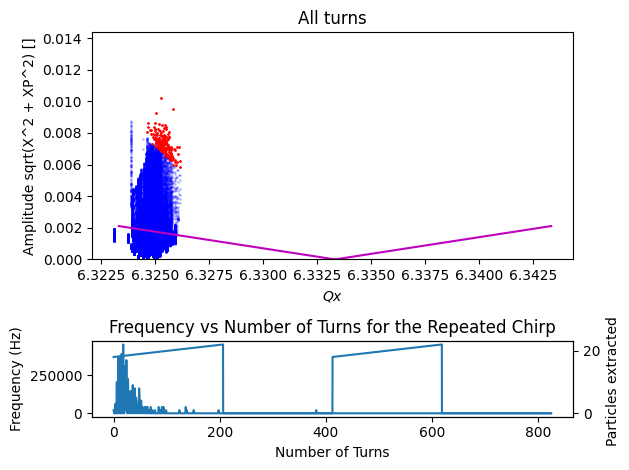

In [422]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax, ax2) = plt.subplots(2,1, height_ratios=[3,1], tight_layout=True)

# Total number of turns
num_turns = len(monitor.x[1])

# Determine global min and max values for x and delta

x = monitor.x[:, :]
px = monitor.px[:, :]
delta = monitor.delta[:, :]

xn = x*1/np.sqrt(betx0)
pxn = (alfx0/np.sqrt(betx0))*x + np.sqrt(betx0)*px
amplitude_monitor = np.sqrt(xn**2 + pxn**2)

x = df.x
px = df.px
xn = x*1/np.sqrt(betx0)
pxn = (alfx0/np.sqrt(betx0))*x + np.sqrt(betx0)*px
amplitude_circulating = np.sqrt(xn**2 + pxn**2)

amplitude_combined = np.concatenate([amplitude_monitor.reshape(-1), amplitude_circulating])
delta_combined = np.concatenate([df.delta, monitor.delta[:,0]])

amplitude_min = np.min(amplitude_combined)
amplitude_max = np.max(amplitude_combined)
delta_min = np.min(delta_combined)
delta_max = np.max(delta_combined)

# Add second plot
ax2.plot(turns_repeated, freq_repeated)
ax2.set_xlabel('Number of Turns')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_title('Frequency vs Number of Turns for the Repeated Chirp')

ax3=ax2.twinx()
ax3.plot(number_part_extracted_list)
ax3.set_ylabel('Particles extracted ')

for frame in range(0, num_turns, 3):

    # Particles monitor and circulating
    x = monitor.x[:, frame] - twiss_after_makethin.loc["pe.smh57"].x
    px = monitor.px[:, frame] - twiss_after_makethin.loc["pe.smh57"].px
    delta = monitor.delta[:, frame]

    Qx_monitor = Qx + Qxp*delta

    x_betatronic = x - twiss_after_makethin.loc["pe.smh57"].dx * delta
    px_betatronic = px - twiss_after_makethin.loc["pe.smh57"].dpx * delta


    xn = x_betatronic*1/np.sqrt(betx0)
    pxn = (alfx0/np.sqrt(betx0))*x_betatronic + np.sqrt(betx0)*px_betatronic
    amplitude = np.sqrt(xn**2 + pxn**2)

    ax.scatter(Qx_monitor, amplitude, s=1, alpha=0.2, c="b")

    # Particle extracted
    x = df.loc[df.at_turn == frame].x - twiss_after_makethin.loc["pe.smh57"].x
    px = df.loc[df.at_turn == frame].px - twiss_after_makethin.loc["pe.smh57"].px
    delta = df.loc[df.at_turn == frame].delta

    x_betatronic = x - twiss_after_makethin.loc["pe.smh57"].dx * delta
    px_betatronic = px - twiss_after_makethin.loc["pe.smh57"].dpx * delta

    xn = x_betatronic*1/np.sqrt(betx0)
    pxn = (alfx0/np.sqrt(betx0))*x_betatronic + np.sqrt(betx0)*px_betatronic
    amplitude = np.sqrt(xn**2 + pxn**2)
    

    Qx_delta = Qx + Qxp*delta

    ax.scatter(Qx_delta, amplitude, s=1, c="r", alpha=1.0)
    
# Virtual sextupole
S_virtual = 76.603649

dQ = np.linspace(-0.01, 0.01, 100)
Ax = (48*np.sqrt(3)*np.pi)**(1/2)*dQ/S_virtual

ax.plot(dQ + 6 + 1/3, Ax, c="m")
ax.plot(dQ + 6 + 1/3, -Ax, c="m")

ax.set_title('All turns')
ax.set_xlabel("$Qx$")
ax.set_ylabel("Amplitude sqrt(X^2 + XP^2) []")

# Set fixed axis limits
# ax.set_xlim(6.32, 6.34)
ax.set_ylim(amplitude_min, amplitude_max)

plt.show()


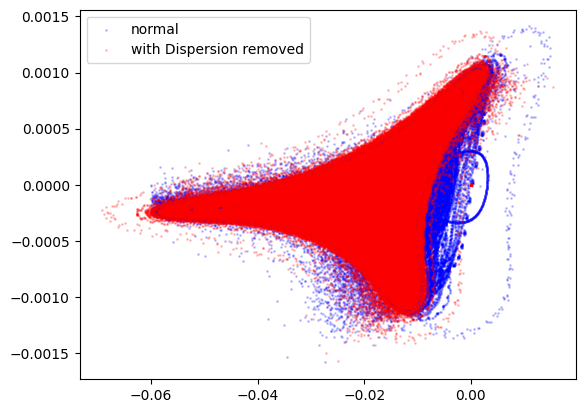

In [405]:
fig, ax = plt.subplots()

x = monitor.x[:, :]
px = monitor.px[:, :]
delta = monitor.delta[:, :]

Qx_monitor = Qx + Qxp*delta

x_betatronic = x - twiss_after_makethin.loc["pe.smh57"].dx * delta
px_betatronic = px - twiss_after_makethin.loc["pe.smh57"].dpx * delta

xn = x_betatronic*1/np.sqrt(betx0)
pxn = (alfx0/np.sqrt(betx0))*x_betatronic + np.sqrt(betx0)*px_betatronic
amplitude = np.sqrt(xn**2 + pxn**2)

ax.scatter(x, px, s=1, alpha=0.2, c="b", label="normal")
ax.scatter(x_betatronic, px_betatronic, s=1, alpha=0.2, c="r", label="with Dispersion removed")

ax.legend(loc="upper left")

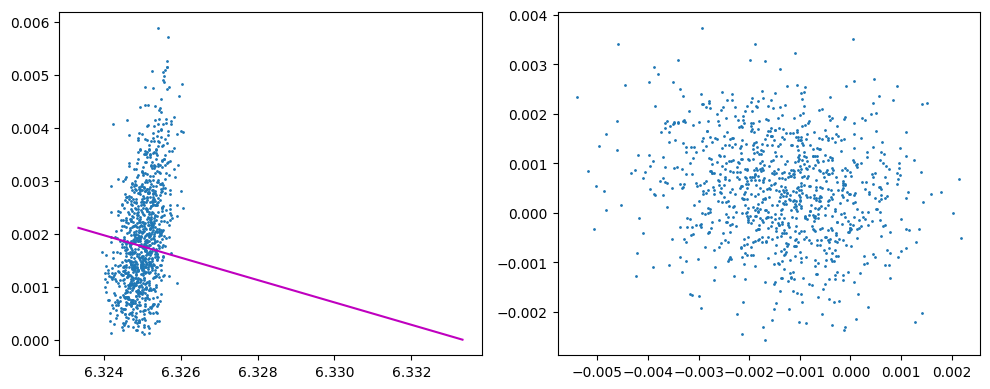

In [455]:
turn = 0

# Particles monitor and circulating
x = monitor.x[:, turn]  - twiss_after_makethin.loc["pe.smh57"].x
px = monitor.px[:, turn] - twiss_after_makethin.loc["pe.smh57"].px
delta = monitor.delta[:, turn]

Qx_monitor = Qx + Qxp*delta

x_betatronic = x - twiss_after_makethin.loc["pe.smh57"].dx * delta
px_betatronic = px - twiss_after_makethin.loc["pe.smh57"].dpx * delta

xn = x_betatronic*1/np.sqrt(betx0)
pxn = (alfx0/np.sqrt(betx0))*x_betatronic + np.sqrt(betx0)*px_betatronic
amplitude = np.sqrt(xn**2 + pxn**2)

fig,ax = plt.subplots(1,2, tight_layout=True, figsize=(10,4))
ax[0].scatter(Qx_monitor, amplitude, s=1)
ax[1].scatter(xn, pxn, s=1)

# Virtual sextupole
S_virtual = 76.603649

dQ = np.linspace(-0.01, 0.00, 100)
Ax = (48*np.sqrt(3)*np.pi)**(1/2)*dQ/S_virtual

ax[0].plot(dQ + 6 + 1/3, -Ax, c="m")

In [458]:
# Define variables here
# ...

frames = []  # This will store the file names of all the frames

for turn in range(n_turn):  # Replace n_turns with the number of turns you have

    # Update variables here based on the current turn
    x = monitor.x[:, turn] - twiss_after_makethin.loc["pe.smh57"].x

    px = monitor.px[:, turn] - twiss_after_makethin.loc["pe.smh57"].px
    delta = monitor.delta[:, turn]

    Qx_monitor = Qx + Qxp*delta

    x_betatronic = x - twiss_after_makethin.loc["pe.smh57"].dx * delta
    px_betatronic = px - twiss_after_makethin.loc["pe.smh57"].dpx * delta

    xn = x_betatronic*1/np.sqrt(betx0)
    pxn = (alfx0/np.sqrt(betx0))*x_betatronic + np.sqrt(betx0)*px_betatronic
    amplitude = np.sqrt(xn**2 + pxn**2)

    fig,ax = plt.subplots(1,2, tight_layout=True, figsize=(10,4))
    ax[0].scatter(Qx_monitor, amplitude, s=1)
    ax[1].scatter(xn, pxn, s=1)


    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
    ax[0].scatter(Qx_monitor, amplitude, s=1)
    ax[1].scatter(xn, pxn, s=1)
    ax[0].plot(dQ + 6 + 1/3, -Ax, c="m")

    # Save the figure to a file
    frame_filename = f'frame_{turn}.png'
    plt.savefig(frame_filename)
    frames.append(frame_filename)  # Save the filename to use later

    # Clear the current figure for the next frame
    plt.clf()

# Create a GIF from the frames
with imageio.get_writer('movie.gif', mode='I') as writer:
    for frame_filename in frames:
        image = imageio.imread(frame_filename)
        writer.append_data(image)

# Optionally remove frames
for frame_filename in frames:
   os.remove(frame_filename)


/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_6832/2118332442.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(1,2, tight_layout=True, figsize=(10,4))
/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_6832/2118332442.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_filename)


In [ ]:
# Optionally remove frames
for frame_filename in frames:
   os.remove(frame_filename)

In [ ]:
def data_gen(turns):
    for turn in range(turns):
        x = monitor.x[:, turn]  - twiss_after_makethin.loc["pe.smh57"].x
        px = monitor.px[:, turn] - twiss_after_makethin.loc["pe.smh57"].px
        delta = monitor.delta[:, turn]

        Qx_monitor = Qx + Qxp*delta

        x_betatronic = x - twiss_after_makethin.loc["pe.smh57"].dx * delta
        px_betatronic = px - twiss_after_makethin.loc["pe.smh57"].dpx * delta

        xn = x_betatronic*1/np.sqrt(betx0)
        pxn = (alfx0/np.sqrt(betx0))*x_betatronic + np.sqrt(betx0)*px_betatronic
        amplitude = np.sqrt(xn**2 + pxn**2)

        yield Qx_monitor, amplitude, xn, pxn

def update(data):
    Qx_monitor, amplitude, xn, pxn = data
    scat1.set_offsets(np.c_[Qx_monitor, amplitude])
    scat2.set_offsets(np.c_[xn, pxn])

    return scat1, scat2,

fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))

# Set initial scatter plots
scat1 = ax[0].scatter([], [], s=1)
scat2 = ax[1].scatter([], [], s=1)

# Virtual sextupole
S_virtual = 76.603649

dQ = np.linspace(-0.01, 0.00, 100)
Ax = (48*np.sqrt(3)*np.pi)**(1/2)*dQ/S_virtual

ax[0].plot(dQ + 6 + 1/3, -Ax, c="m")

ani = FuncAnimation(fig, update, frames=data_gen(turns), interval=100, blit=True)

ani.save('animation.gif', writer='imagemagick')
